<h2><b>To predict Netgain for the advertisements given various features.</b></h2>

In [65]:
import os

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

In [1]:
path="/home/ad_success/"                                                                                     #Enter Datapath Here

<b><h2>Reading Data</h2></b>

---



---



In [3]:
train=pd.read_csv(path+"Train.csv")
test=pd.read_csv(path+"Test.csv")
train=train.drop(["id"],axis=1)
train=train.drop_duplicates(keep='first', inplace=False)
print(train.shape)

(9325, 11)


<b><h2>Data Exploration</h2></b>

---



---



In [37]:
train.head()

,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,False
1,Married-civ-spouse,Pharma,Comedy,Male,45,Primetime,United-States,0.027465,Low,No,False
2,Divorced,Entertainment,Comedy,Female,45,Primetime,United-States,0.027465,High,Yes,False
3,Separated,Political,Infomercial,Female,40,Primetime,United-States,0.027465,Low,No,False
4,Married-civ-spouse,Pharma,Comedy,Male,48,Primetime,United-States,0.027465,High,No,True


><li>There are 10 Features.</li><br>
><li>Target Variables is "netgain".</li>

<h4><b>Distribution of Target Variable</b></h4>

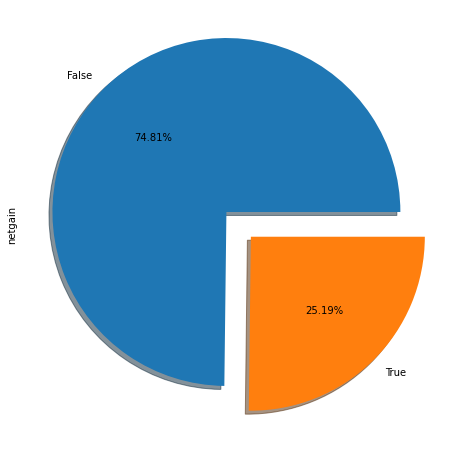

In [6]:
train['netgain'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.2f%%',shadow=True,figsize=(10,8))

Clearly,
><li>the classes are not imbalanced.</li>

><b>Distribution within Categorical Variables.  </b>

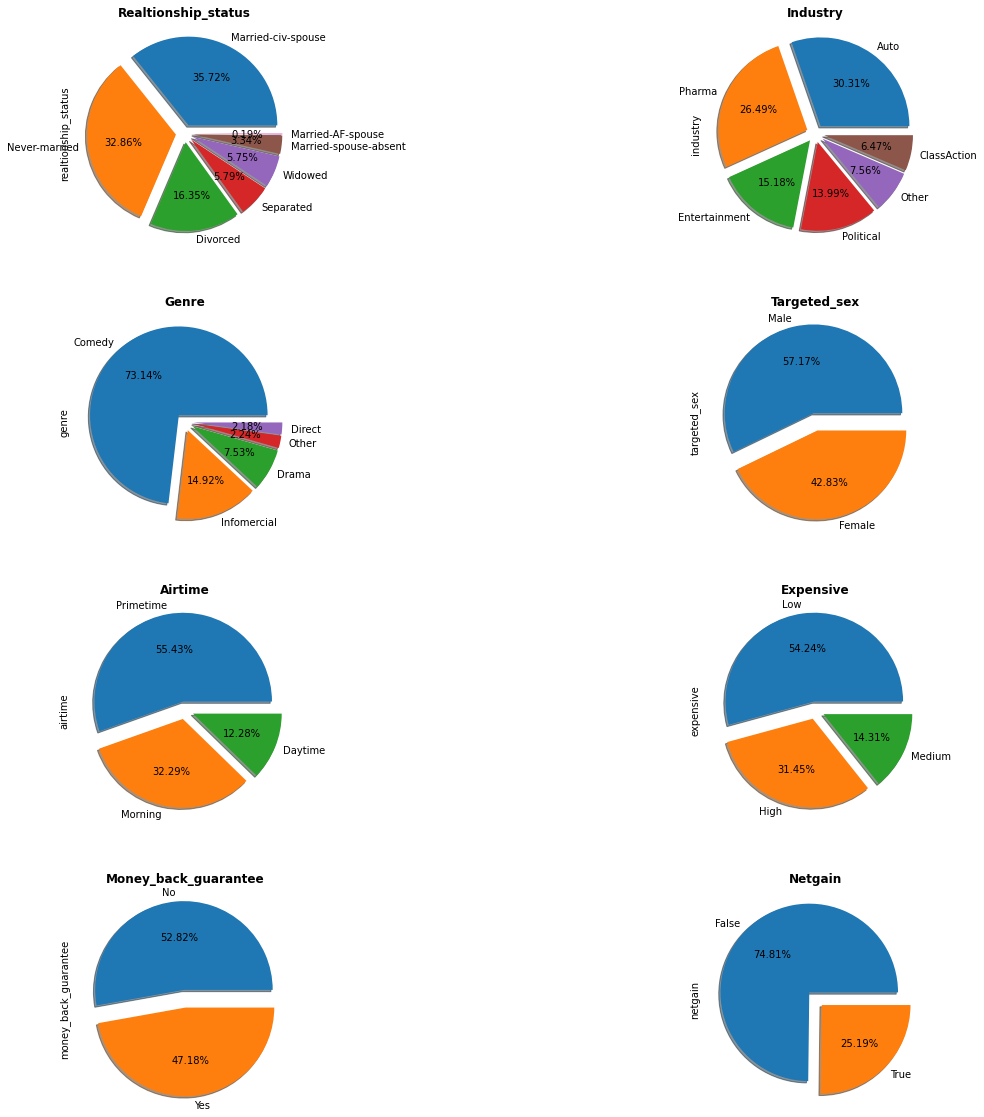

In [168]:
k=1
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in train.columns:
    if len(train[i].value_counts())<10:
      explode=[0.1]*len(train[i].value_counts())
      ax = fig.add_subplot(4, 2, k)
      k=k+1
      plt.title(i.capitalize(),fontweight="bold")
      train[i].value_counts().plot.pie(explode=explode,autopct='%1.2f%%',shadow=True,figsize=(20,20))

<b>Observations</b>:-
><li>The Target variable <b>"Netgain"</b> has distribution ratio of 75:25. So It is not a case of imbalanced classes </li><br>
><li>The feature <b>"realtionship_status"</b> has few categories that counts less than 5% of the total observations :-
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Married-AF-spouse ---------> 0.19%</li>
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Married-spouse-absent 
 ----> 3.34%</li><br><br>
><li>The feature <b>"genre"</b> has few categories that counts less than 5% of the total observations :-
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Other ----> 2.24%</li>
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Direct 
 ----> 2.18%</li>
<br>
 <br>
><li>The categories which occurs very less number of times can be considered as outliers and can be replaced by the more frequent observations.</li><br>
><li>The features <b>"targeted_sex"</b> and <b>"money_back_guarantee"</b> are binary features and the distribution of categories within features is also even.</li><br>
><li>74% of the Ad's are from <b>Comedy</b> Genre .</li><br>
><li>Ad's are made to target both type of <b>targeted_sex</b> equally.</li><br>
><li>53% of the advertised product offers a <b>money_back_guarantee</b> in the case of customer dissatisfaction.</li><br>
><li>55% of the advertisement were aired on Primetime <b>Airtime</b> .</li><br>
><li>30% of the product advertised belong to Auto <b>Industry</b>.</li><br>
><li>27% of the product advertised belong to Pharma <b>Industry</b>.</li><br>
><li>54% of the product advertised are made of low <b>Expensive</b> budget.</li><br>
><li>32% of the product advertised are made of high <b>Expensive</b> budget.</li>


In [8]:
num_cols = train._get_numeric_data().columns
print(num_cols)
set(train.columns)-set(num_cols)

Index(['average_runtime(minutes_per_week)', 'ratings', 'netgain'], dtype='object')


{'airlocation',
 'airtime',
 'expensive',
 'genre',
 'industry',
 'money_back_guarantee',
 'realtionship_status',
 'targeted_sex'}

><b>Distribution of Numerical Features.</b>
>><ol><li>ratings</li>
>><li>average_runtime(minutes_per_week)</li></ol>

><b>1) ratings

0.0503507756210064


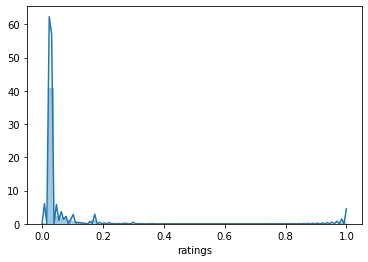

In [6]:
sns.distplot(train["ratings"]);
print(np.mean(train["ratings"]))

<b>Observations</b>:-
><li>The Feature is centered around close to the minimum value i.e. 0.05
<br>
><li>There are so many outliers present.<br>
><li>The rating 0.027 has occured so many times.



><b>2) <em>average_runtime(minutes_per_week)</em>

39.79581769436997


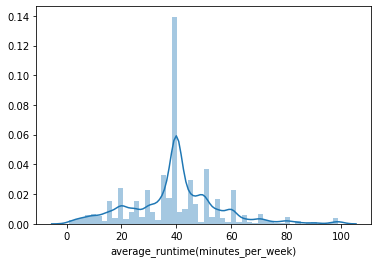

In [7]:
sns.distplot(train["average_runtime(minutes_per_week)"]);
print(np.mean(train["average_runtime(minutes_per_week)"]))

<b>Observations</b>:-

><li>The Feature is centered around close to the median value i.e. 39.79.
<br>
><li>There are less outliers present.
<br>
><li>The observations 40 has occured so many times. 

<b><h2>Handling Missing Values</h2></b>


---


---



In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9325 entries, 0 to 26045
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   realtionship_status                9325 non-null   object 
 1   industry                           9325 non-null   object 
 2   genre                              9325 non-null   object 
 3   targeted_sex                       9325 non-null   object 
 4   average_runtime(minutes_per_week)  9325 non-null   int64  
 5   airtime                            9325 non-null   object 
 6   airlocation                        9325 non-null   object 
 7   ratings                            9325 non-null   float64
 8   expensive                          9325 non-null   object 
 9   money_back_guarantee               9325 non-null   object 
 10  netgain                            9325 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(8)
memory usag

><li>No Missing Values

<b><h2>Handling Outliers</h2></b>

---



---



><b>Outliers Detection.</b>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


40.0
0.0274646723


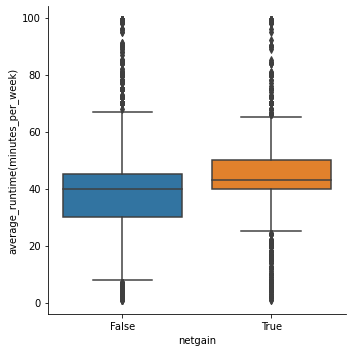

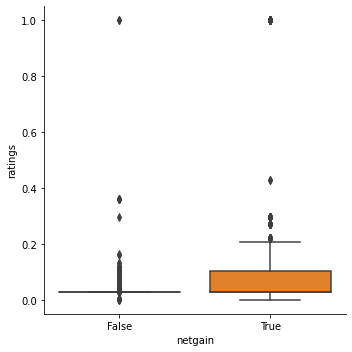

In [ ]:
fig.set_figheight(8)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i,j in enumerate(train.columns):
    if j in ["ratings","average_runtime(minutes_per_week)"]:
        ax = fig.add_subplot(1,2, k)
        k=k+1
        print(np.median(train[j]))
        sns.catplot(x="netgain",y=j,data=train,kind="box")

><li>We observe that there is a greater variability as well as larger outliers.</li>

In [128]:
print(train["ratings"].describe())

count    9325.000000
mean        0.050351
std         0.108276
min         0.000000
25%         0.027465
50%         0.027465
75%         0.027465
max         1.000000
Name: ratings, dtype: float64


><li>75% of the observations have ratings < 0.027.</li>

><b>Calculating IQR

In [24]:
Q0 = train["ratings"].quantile(0)
Q1 = train["ratings"].quantile(0.25)
Q2 = train["ratings"].quantile(0.50)
Q3 = train["ratings"].quantile(0.75)
Q4 = train["ratings"].quantile(1)
IQR=Q3-Q1
print("{val1:0.2f} ,{val2:0.2f} ,{val3:0.2f} ,{val4:0.2f} ".format(val1=Q1,val2=Q2,val3=Q3,val4=Q4))
print(IQR)

0.03 ,0.03 ,0.03 ,1.00 
0.0


In [38]:
"{val:0.2f}".format(val=Q1)

'0.03'

><li>The Minimum value of ratings is 0.
><li>The First , Second and Third Quantile are same and = 0.27.
><li>Most of the ratings are less than or equal to 0.027.
><li>The Maximum value of ratings is 1.

In [39]:
print(sum(round(train["ratings"],3)==0.027)/len(train)*100)
print(sum(train["ratings"]<=0.3)/len(train)*100)

81.07238605898124
98.7774798927614


><li>81% of the total observations have ratings equal to 0.2.
><li>Approx,99% of the total observations have ratings less than or equal to 0.2.

><b>Distribution of target variable where ratings > 0.3.

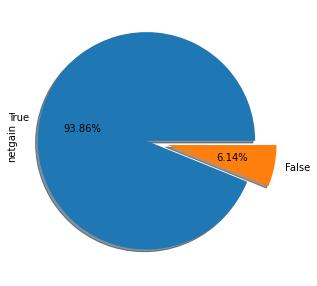

In [36]:
temp_df=train[train["ratings"]>0.3]
temp_df["netgain"].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.2f%%',shadow=True,figsize=(5,5))

><li>Most of the observations in outliers  have netgain = True.</li>
><li>This pattern can be exploited to make predictions in future , specially when ratings are more than 0.3.</li>

><b>Outliers Removal

In [40]:
train=train[train["ratings"].between(train["ratings"].quantile(0), train["ratings"].quantile(.981))].reset_index(drop=False)
train.shape

(9148, 12)

<h2><b>Feature Engineering</b></h2>


---


---



><b>Trends in Categorical Features w.r.t. Target Variables.</b>



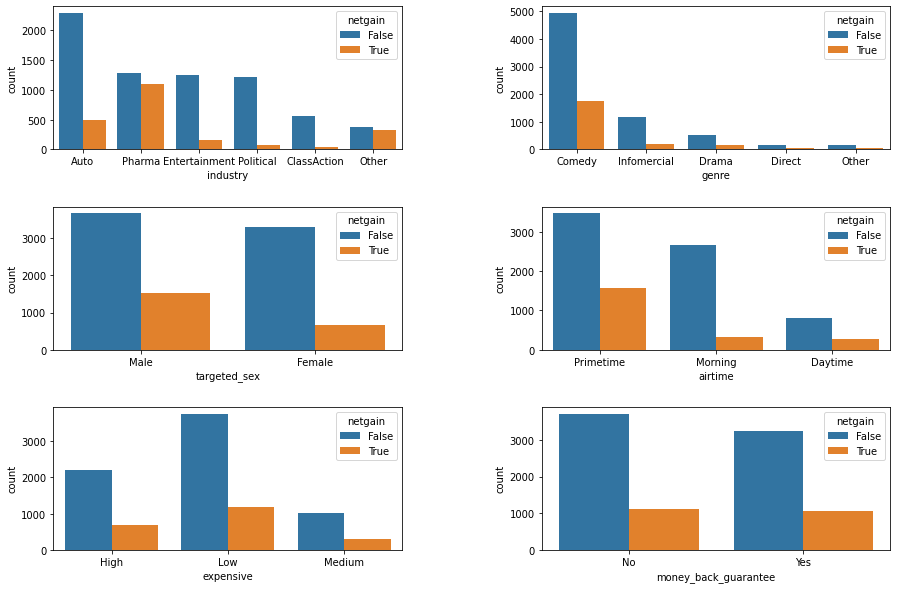

In [172]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i,j in enumerate(train.columns):
    if j in ["money_back_guarantee","expensive","airtime","targeted_sex","genre","industry"]:
        ax = fig.add_subplot(3, 2, k)
        k=k+1
        sns.countplot(x=j,data=train,hue="netgain")

<b>Observations</b>:-
><li>Most of the observations where netgain = "True" have:-</li>
>
>><li>Industry = Pharma</li>
>
>><li>Genre = Comedy</li>
>
>><li>airtime = Primetime</li>

<b>Trends in Numerical Features w.r.t. Target Variables.</b>
><ol><li>ratings vs netgain</li>
><li>average_runtime(minutes_per_week) vs netgain</li></ol>

<b>ratings vs netgain</b>

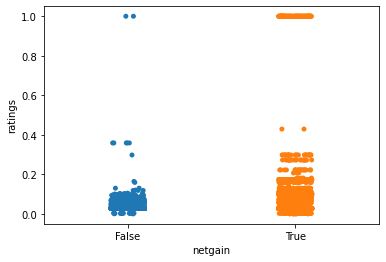

In [9]:
sns.stripplot(x="netgain", y="ratings", data=train)

><li>Most of the ratings lies between 0.0 and 0.3.

><b><em>average_runtime(minutes_per_week) vs netgain</em>

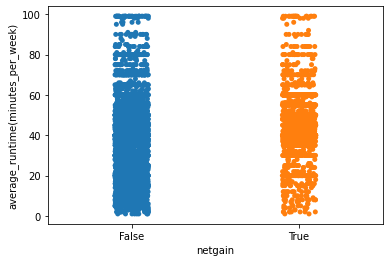

In [41]:
sns.stripplot(x="netgain", y="average_runtime(minutes_per_week)", data=train)

><b>ratings vs average_runtime(minutes_per_week) and netgain</b>

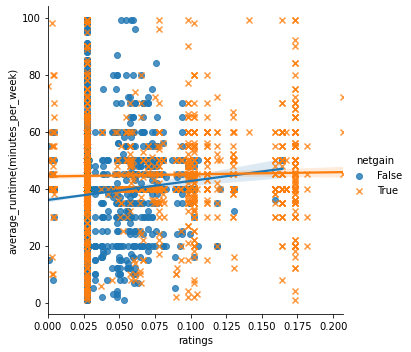

In [81]:
sns.lmplot(x="ratings", y="average_runtime(minutes_per_week)", data=train,hue="netgain",markers=["o", "x"]);

><b>Fitting logistic regression on  "ratings" vs "netgain".</b>

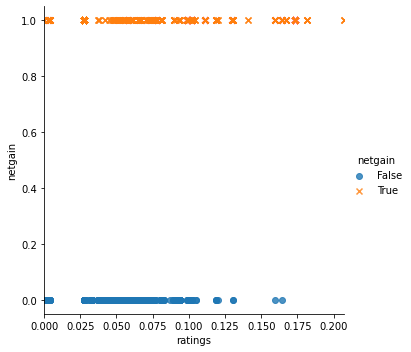

In [77]:
sns.lmplot(y="netgain", x="ratings", data=train,
           logistic=True,hue="netgain",markers=["o", "x"]);

><li>No logistic relation between "netgain" and "ratings".

><b>Fitting logistic regression on  "average_runtime(minutes_per_week)" vs "netgain".</b>

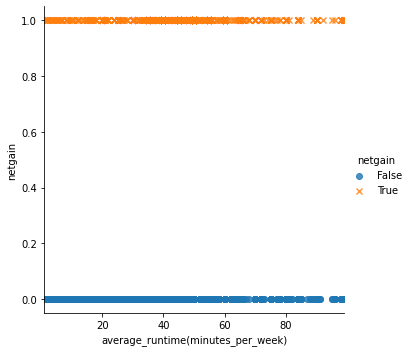

In [80]:
sns.lmplot(y="netgain", x="average_runtime(minutes_per_week)", data=train,
           logistic=True,hue="netgain",markers=["o", "x"]);

><li>No logistic relation between "netgain" and "average_runtime(minutes_per_week)"


<h2><b>Data Preparation</b> </h2>

---



---



In [45]:
data=pd.get_dummies(train, prefix_sep='_', drop_first=True)
data.head()

,index,average_runtime(minutes_per_week),ratings,netgain,realtionship_status_Married-AF-spouse,realtionship_status_Married-civ-spouse,realtionship_status_Married-spouse-absent,realtionship_status_Never-married,realtionship_status_Separated,realtionship_status_Widowed,industry_ClassAction,industry_Entertainment,industry_Other,industry_Pharma,industry_Political,genre_Direct,genre_Drama,genre_Infomercial,genre_Other,targeted_sex_Male,airtime_Morning,airtime_Primetime,airlocation_Canada,airlocation_China,airlocation_Columbia,airlocation_Cuba,airlocation_Dominican-Republic,airlocation_Ecuador,airlocation_El-Salvador,airlocation_England,airlocation_France,airlocation_Germany,airlocation_Greece,airlocation_Guatemala,airlocation_Haiti,airlocation_Holand-Netherlands,airlocation_Honduras,airlocation_Hong,airlocation_Hungary,airlocation_India,airlocation_International,airlocation_Iran,airlocation_Ireland,airlocation_Italy,airlocation_Jamaica,airlocation_Japan,airlocation_Laos,airlocation_Mexico,airlocation_Nicaragua,airlocation_Outlying-US(Guam-USVI-etc),airlocation_Peru,airlocation_Philippines,airlocation_Poland,airlocation_Portugal,airlocation_Puerto-Rico,airlocation_Scotland,airlocation_South,airlocation_Taiwan,airlocation_Thailand,airlocation_Trinadad&Tobago,airlocation_United-States,airlocation_Vietnam,airlocation_Yugoslavia,expensive_Low,expensive_Medium,money_back_guarantee_Yes
0,0,45,0.027465,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,45,0.027465,False,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,2,45,0.027465,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,3,40,0.027465,False,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,4,48,0.027465,True,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


<h2><b>Correlation</b></h2>

---



---



In [48]:
corr_matrix = data.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.30)]

In [49]:
target=data["netgain"]

print(data.shape)

data=data.drop(to_drop, axis=1)

print(data.shape)

(9148, 66)
(9148, 52)


<b><h2>Model Fitting</h2></b>

---



---



><b><h2>Logistic Regression</h2></b>

>><b>HyperParameter Tuning</b>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

C_param_range = [0.001,0.01,0.1,1,5]

for i in C_param_range:
    
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0)

    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    
    print("For value of c = {c} , accuracy_score = {acc:.2f}%".format(c=i,acc=accuracy_score(y_test,y_pred)*100))

For value of c = 0.001 , accuracy_score = 75.16%
For value of c = 0.01 , accuracy_score = 75.22%
For value of c = 0.1 , accuracy_score = 74.89%
For value of c = 1 , accuracy_score = 74.86%
For value of c = 5 , accuracy_score = 74.53%


>><b>Training</b>

In [63]:
lr = LogisticRegression(penalty = 'l2', C = 0.001,random_state = 0)

lr.fit(X_train, y_train)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

>><b>Prediction & Evaluation</b>

In [64]:
y_pred = lr.predict(X_test)

results = confusion_matrix(y_test, y_pred) 

print( 'Confusion Matrix :')

print(results) 

print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 

print ('Report : ')

print (classification_report(y_test, y_pred))

Confusion Matrix :
[[2264    4]
 [ 635  116]]
Accuracy Score : 0.788340510102683
Report : 
              precision    recall  f1-score   support

       False       0.78      1.00      0.88      2268
        True       0.97      0.15      0.27       751

    accuracy                           0.79      3019
   macro avg       0.87      0.58      0.57      3019
weighted avg       0.83      0.79      0.72      3019



><b><h2>XGBOOST</h2></b>

>><b>HyperParameter Tuning

In [ ]:
param_test1 = {
 'max_depth':range(4,6,10),
 'min_child_weight':range(1,6,2),
 'n_estimators':[500,750,1000],
 'gamma':[4,8,10],
 'colsample_bytree':[0.6,0.7,0.8],
 'learning_rate':[0.1,0.01,0.001],
 "min_samples_leaf" : [1, 5, 10], 
 "min_samples_split" : [2, 4, 10, 12, 16],
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(data,target)

In [ ]:
gsearch1.cv_results_
gsearch1.best_params_
gsearch1.best_score_

>><b>Training</b>

In [66]:
train__std = StandardScaler(with_std=True,with_mean=True).fit_transform(data)

seed = 7

test_size = 0.33

X_train, X_test, y_train, y_test = model_selection.train_test_split(train__std, target, test_size=test_size, random_state=seed)

model = xgb.XGBClassifier( learning_rate =0.015,
 n_estimators=750,n_jobs=10,
 max_depth=3,
 min_child_weight=5,
 gamma=10,
subsample=0.7,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha = 0.4,
 seed=27)

print(model) 

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=10,
              learning_rate=0.015, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=750, n_jobs=10,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.7, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=10,
              learning_rate=0.015, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=750, n_jobs=10,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.7, verbosity=1)

>><b><h2>Prediction & Evaluation</h2>

In [68]:
y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)

results = confusion_matrix(y_test, y_pred)

print( 'Confusion Matrix :')

print(results) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

print ('Report : \n')

print (classification_report(y_test, y_pred))

Confusion Matrix :
[[2242   26]
 [ 520  231]]
Accuracy: 81.91%
Report : 

              precision    recall  f1-score   support

       False       0.81      0.99      0.89      2268
        True       0.90      0.31      0.46       751

    accuracy                           0.82      3019
   macro avg       0.86      0.65      0.67      3019
weighted avg       0.83      0.82      0.78      3019



With this XGBOOST model , I was able to get a decent score on the leaderboard.

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;END!